# FairPredictor Autogluon Examples
This file contains demo code for an extended version of the example in Readme.md (additionally handling more fairness over multiple groups),  and enforcing a range of fairness definition on COMPAS.

FairPredictor is a postprocessing approach for enforcing fairness, with support for a wide range of performance metrics and fairness criteria, and support for inferred attributes, i.e. it does not require access to protected attributes at test time. 
Under the hood, FairPredictor works by adjusting the decision boundary for each group individually. Where groups are not available, it makes use of inferred group membership to adjust decision boundaries.

The key idea underlying this toolkit is that for a wide range of use cases, the most suitable classifier should do more than maximize some form of accuracy.
We offer a general toolkit that allows different measures to be optimized and additional constraints to be imposed by tuning the behavior of a binary predictor on validation data.

For example, classifiers can be tuned to maximize performance for a wide range of metrics such as:

* Accuracy
* Balanced Accuracy
* F1 score
* MCC
* Custom utility functions

While also approximately satisfying a wide range of group constraints such as:

* Demographic Parity (The idea that positive decisions should occur at the same rates for all protected groups, for example for men at the same rate as for women)
* Equal Opportunity (The recall should be the same for all protected groups)
* Minimum recall constraints (The recall should be above a particular level for all groups)
* Minimum Precision constraints (The precision should be above a particular level for all groups)
* Custom Fairness Metrics

The full set of constraints and objectives can be seen in Readme.md 

In [1]:
# Load and train a baseline classifier

from autogluon.tabular import TabularDataset, TabularPredictor
from oxonfair import FairPredictor 
from oxonfair.utils import group_metrics as gm
train_data = TabularDataset('https://autogluon.s3.amazonaws.com/datasets/Inc/train.csv')
test_data = TabularDataset('https://autogluon.s3.amazonaws.com/datasets/Inc/test.csv')
predictor = TabularPredictor(label='class').fit(train_data=train_data)

/opt/miniconda3/envs/ag/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No path specified. Models will be saved in: "AutogluonModels/ag-20240519_153001"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonM

In [2]:
# Modify predictor to enforce fairness over the train_data with respect to groups given by the column 'sex'
fpredictor = FairPredictor(predictor,train_data,'sex')
# Maximize accuracy while enforcing that the demographic parity (the difference in positive decision rates between men and women is at most 0.02)
fpredictor.fit(gm.accuracy,gm.demographic_parity,0.02)

In [3]:
# Evaluate on test data
fpredictor.predict(test_data)

0        <=50K
1        <=50K
2         >50K
3        <=50K
4        <=50K
         ...  
9764     <=50K
9765     <=50K
9766     <=50K
9767     <=50K
9768     <=50K
Length: 9769, dtype: object

In [4]:
# Evaluate a range of performance measures, and compare against original classifier on test data
fpredictor.evaluate(test_data, verbose=True)

,original,updated
Accuracy,0.877265,0.852697
Balanced Accuracy,0.796502,0.763159
F1 score,0.713089,0.656317
MCC,0.642414,0.569239
Precision,0.800645,0.735152
Recall,0.642796,0.592752
ROC AUC,0.930603,0.828036


In [5]:
# Evaluate against a range of standard fairness definitions and compare against original classifier on test data
fpredictor.evaluate_fairness(test_data, verbose=True)

,original,updated
Statistical Parity,0.167100,0.007907
Predictive Parity,0.012300,0.354501
Equal Opportunity,0.066524,0.316661
Average Group Difference in False Negative Rate,0.066524,0.316661
Equalized Odds,0.058890,0.190074
Conditional Use Accuracy,0.051897,0.253777
Average Group Difference in Accuracy,0.092900,0.058432
Treatment Equality,0.086631,6.076776


In [6]:
# Evaluate a range of performance measures per group, and compare against original classifier on test data
fpredictor.evaluate_groups(test_data, verbose=True, return_original=True)

Accuracy  Balanced Accuracy  F1 score       MCC  \
         Groups                                                                
original Overall             0.877265           0.796502  0.713089  0.642414   
          Female             0.938887           0.783835  0.673171  0.648939   
          Male               0.845988           0.791469  0.719978  0.621517   
         Maximum difference  0.092900           0.007634  0.046807  0.027422   
updated  Overall             0.852697           0.763159  0.656317  0.569239   
          Female             0.891456           0.878143  0.630052  0.601521   
          Male               0.833025           0.751556  0.664184  0.584853   
         Maximum difference  0.058432           0.126587  0.034132  0.016668   

                             Precision    Recall   ROC AUC  \
         Groups                                              
original Overall              0.800645  0.642796  0.930603   
          Female              0.790076  0.586402  0.947373   
          Male                0.802376  0.652926  0.912286   
         Maximum difference   0.012300  0.066524  0.035087   
updated  Overall              0.735152  0.592752  0.828036   
          Female              0.496732  0.861190  0.947373   
          Male                0.851233  0.544529  0.912286   
         Maximum difference   0.354501  0.316661  0.035087   

                             Number of Datapoints  Positive Count  \
         Groups                                                     
original Overall                           9769.0          2318.0   
          Female                           3289.0           353.0   
          Male                             6480.0          1965.0   
         Maximum difference                3191.0          1612.0   
updated  Overall                           9769.0          2318.0   
          Female                           3289.0           353.0   
          Male                             6480.0          1965.0   
         Maximum difference                3191.0          1612.0   

                             Negative Count  Positive Label Rate  \
         Groups                                                    
original Overall                     7451.0             0.237281   
          Female                     2936.0             0.107327   
          Male                       4515.0             0.303241   
         Maximum difference          1579.0             0.195913   
updated  Overall                     7451.0             0.237281   
          Female                     2936.0             0.107327   
          Male                       4515.0             0.303241   
         Maximum difference          1579.0             0.195913   

                             Positive Prediction Rate  
         Groups                                        
original Overall                             0.190501  
          Female                             0.079659  
          Male                               0.246759  
         Maximum difference                  0.167100  
updated  Overall                             0.191319  
          Female                             0.186075  
          Male                               0.193981  
         Maximum difference                  0.007907

In [7]:
#We can repeat the same analysis using the feature 'race' instead of 'sex'
fpredictor = FairPredictor(predictor,train_data, 'race')
# Maximize accuracy while enforcing that the demographic parity (the difference in positive decision rates between men and women is at most 0.02)
fpredictor.fit(gm.accuracy, gm.demographic_parity, .02)

In [8]:
# Unlike the previous case, we find that demographic parity is still high on test data, although it is improved.
fpredictor.evaluate_fairness(test_data, verbose=True)

,original,updated
Statistical Parity,0.092291,0.058298
Predictive Parity,0.109843,0.208027
Equal Opportunity,0.127146,0.197529
Average Group Difference in False Negative Rate,0.127146,0.197529
Equalized Odds,0.080401,0.122455
Conditional Use Accuracy,0.071534,0.137271
Average Group Difference in Accuracy,0.044549,0.030270
Treatment Equality,0.270631,4.326319


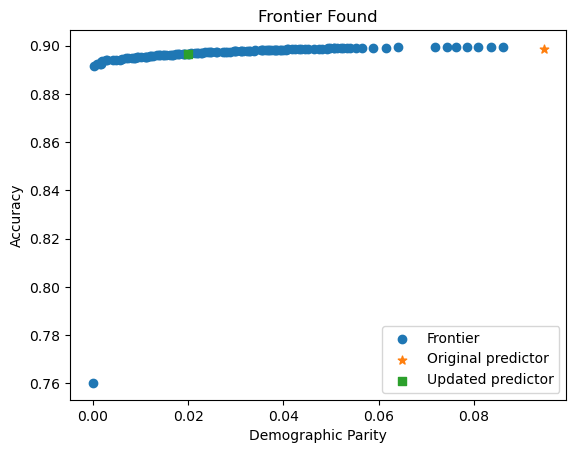

In [9]:
#To debug this, we can look at the Pareto Frontier of solutions considered, on the training set
fpredictor.plot_frontier() 

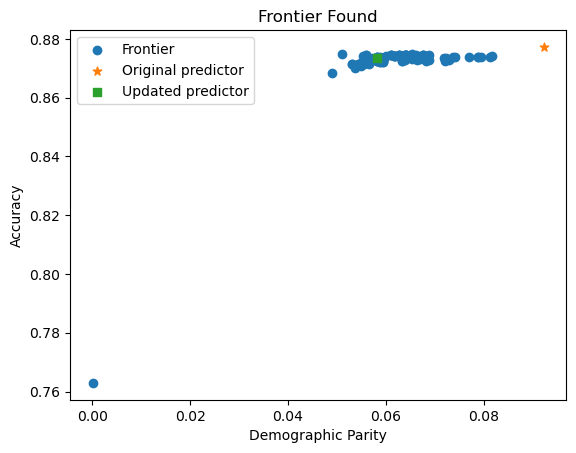

In [10]:
#and on the test set
fpredictor.plot_frontier(test_data) 

In [11]:
#We find that the demographic parity is very different on test data for a range of solutions found.
#By looking at the per group decomposition, we can find out why.
fpredictor.evaluate_groups(test_data, verbose=True)

Accuracy  Balanced Accuracy  F1 score       MCC  \
         Groups                                                                 
original Overall              0.877265           0.796502  0.713089  0.642414   
          Amer-Indian-Eskimo  0.943089           0.681818  0.533333  0.585018   
          Asian-Pac-Islander  0.865854           0.786309  0.690141  0.608854   
          Black               0.934905           0.777394  0.677778  0.657565   
          Other               0.938272           0.792958  0.705882  0.685961   
          White               0.869998           0.796749  0.716340  0.639113   
         Maximum difference   0.077236           0.114931  0.183007  0.100943   
updated  Overall              0.873477           0.795505  0.708215  0.632954   
          Amer-Indian-Eskimo  0.902439           0.782468  0.538462  0.492659   
          Asian-Pac-Islander  0.853659           0.724323  0.606557  0.552697   
          Black               0.910213           0.856171  0.677419  0.634452   
          Other               0.864198           0.879577  0.620690  0.589369   
          White               0.869998           0.795654  0.715298  0.638701   
         Maximum difference   0.056555           0.155254  0.176836  0.146042   

                              Precision    Recall   ROC AUC  \
         Groups                                               
original Overall               0.800645  0.642796  0.930603   
          Amer-Indian-Eskimo   1.000000  0.363636  0.942370   
          Asian-Pac-Islander   0.753846  0.636364  0.907642   
          Black                0.835616  0.570093  0.953450   
          Other                0.857143  0.600000  0.956338   
          White                0.800234  0.648367  0.927530   
         Maximum difference    0.246154  0.284731  0.048696   
updated  Overall               0.782065  0.647110  0.912459   
          Amer-Indian-Eskimo   0.466667  0.636364  0.942370   
          Asian-Pac-Islander   0.822222  0.480519  0.907642   
          Black                0.595745  0.785047  0.953450   
          Other                0.473684  0.900000  0.956338   
          White                0.802709  0.645054  0.927530   
         Maximum difference    0.355556  0.419481  0.048696   

                              Number of Datapoints  Positive Count  \
         Groups                                                      
original Overall                            9769.0          2318.0   
          Amer-Indian-Eskimo                 123.0            11.0   
          Asian-Pac-Islander                 328.0            77.0   
          Black                              891.0           107.0   
          Other                               81.0            10.0   
          White                             8346.0          2113.0   
         Maximum difference                 8265.0          2103.0   
updated  Overall                            9769.0          2318.0   
          Amer-Indian-Eskimo                 123.0            11.0   
          Asian-Pac-Islander                 328.0            77.0   
          Black                              891.0           107.0   
          Other                               81.0            10.0   
          White                             8346.0          2113.0   
         Maximum difference                 8265.0          2103.0   

                              Negative Count  Positive Label Rate  \
         Groups                                                     
original Overall                      7451.0             0.237281   
          Amer-Indian-Eskimo           112.0             0.089431   
          Asian-Pac-Islander           251.0             0.234756   
          Black                        784.0             0.120090   
          Other                         71.0             0.123457   
          White                       6233.0             0.253175   
         Maximum difference           6162.0       

In [12]:
#The groups with the smallest Positive Prediction Rate (American-Indian-Eskimo, and Asian-Pacific-Islander) 
# only have around 100-300 samples making it impossible to accurately evaluate demographic parity, while the
# group labelled 'Other' has even less data.
# Moreover, on training data we find that there are less than 350 people identified as American-Indian-Eskimo, 
# meaning that it is not possible to predict if the positive prediction rate will hold on new data. 
fpredictor.evaluate_groups(verbose=True)

Accuracy  Balanced Accuracy  F1 score       MCC  \
         Groups                                                                 
original Overall              0.898523           0.831765  0.768764  0.709484   
          Amer-Indian-Eskimo  0.948127           0.824595  0.763158  0.746602   
          Asian-Pac-Islander  0.901763           0.864449  0.815748  0.750420   
          Black               0.946231           0.814414  0.742424  0.724709   
          Other               0.944615           0.796491  0.727273  0.718079   
          White               0.892028           0.830259  0.768391  0.703640   
         Maximum difference   0.056099           0.067958  0.088475  0.046780   
updated  Overall              0.896604           0.832767  0.767093  0.704941   
          Amer-Indian-Eskimo  0.919308           0.924655  0.745455  0.720093   
          Asian-Pac-Islander  0.887490           0.811128  0.759857  0.711569   
          Black               0.936215           0.920506  0.773408  0.747124   
          Other               0.926154           0.947149  0.764706  0.747758   
          White               0.891908           0.828743  0.767088  0.702963   
         Maximum difference   0.048726           0.136021  0.027954  0.044795   

                              Precision    Recall   ROC AUC  \
         Groups                                               
original Overall               0.847390  0.703490  0.959697   
          Amer-Indian-Eskimo   0.906250  0.659091  0.982073   
          Asian-Pac-Islander   0.854785  0.780120  0.967639   
          Black                0.882883  0.640523  0.981742   
          Other                0.923077  0.600000  0.989825   
          White                0.844862  0.704615  0.955919   
         Maximum difference    0.078215  0.180120  0.033906   
updated  Overall               0.834023  0.710108  0.946357   
          Amer-Indian-Eskimo   0.621212  0.931818  0.982073   
          Asian-Pac-Islander   0.938053  0.638554  0.967639   
          Black                0.678161  0.899782  0.981742   
          Other                0.629032  0.975000  0.989825   
          White                0.848018  0.700259  0.955919   
         Maximum difference    0.316841  0.336446  0.033906   

                              Number of Datapoints  Positive Count  \
         Groups                                                      
original Overall                           39073.0          9369.0   
          Amer-Indian-Eskimo                 347.0            44.0   
          Asian-Pac-Islander                1191.0           332.0   
          Black                             3794.0           459.0   
          Other                              325.0            40.0   
          White                            33416.0          8494.0   
         Maximum difference                33091.0          8454.0   
updated  Overall                           39073.0          9369.0   
          Amer-Indian-Eskimo                 347.0            44.0   
          Asian-Pac-Islander                1191.0           332.0   
          Black                             3794.0           459.0   
          Other                              325.0            40.0   
          White                            33416.0          8494.0   
         Maximum difference                33091.0          8454.0   

                              Negative Count  Positive Label Rate  \
         Groups                                                     
original Overall                     29704.0             0.239782   
          Amer-Indian-Eskimo           303.0             0.126801   
          Asian-Pac-Islander           859.0             0.278757   
          Black                       3335.0             0.120980   
          Other                        285.0             0.123077   
          White                      24922.0             0.254190   
         Maximum difference          24637.0       

## Fairness on COMPAS using Inferred Attributes

We demonstrate how to enforce a wide range of fairness definitions on the COMPAS dataset. This dataset records paroles caught violating the terms of parole. As it measures who was caught, it is strongly influenced by policing and environmental biases, and should not be confused with a measurement of who actually violated their terms of parole. See [this paper](https://datasets-benchmarks-proceedings.neurips.cc/paper/2021/file/92cc227532d17e56e07902b254dfad10-Paper-round1.pdf) for a discussion of its limitations and caveats. 
We use it because it is a standard fairness dataset that captures such strong differences in outcome between people identified as African-American and everyone else, that classifiers trained on this dataset violate most definitions of fairness.

As many of the ethnic groups are too small for reliable statistical estimation, we only consider differences is in outcomes between African-Americans vs. everyone else (labeled as other).
We load and preprocess the COMPAS dataset, splitting it into three roughly equal partitions of train, validation, and test:

In [13]:
import numpy as np
import pandas as pd
from oxonfair import inferred_attribute_builder
all_data = pd.read_csv('https://github.com/propublica/compas-analysis/raw/master/compas-scores-two-years.csv')
condensed_data=all_data[['sex','race','age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'age_cat', 'c_charge_degree','two_year_recid']].copy()
condensed_data.replace({'Caucasian':'Other', 'Hispanic':'Other', 'Native American':'Other', 'Asian':'Other'},inplace=True)
train=condensed_data.sample(frac=0.3, random_state=0)
val_and_test=condensed_data.drop(train.index)
val=val_and_test.sample(frac=0.5, random_state=0)
test=val_and_test.drop(val.index)

In [14]:
# To enforce fairness constraints without access to protected attributes at test time, we train two classifiers to infer the 2-year recidivism rate, and ethnicity.
  
predictor2, protected = inferred_attribute_builder(train, 'two_year_recid', 'race')


No path specified. Models will be saved in: "AutogluonModels/ag-20240519_153410"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20240519_153410"
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.10.13
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.4.0: Fri Mar 15 00:12:49 PDT

In [15]:
# From these a single predictor that maximizes acuracy while reducing the demographic parity violation to less than 2.5% can be trained by running:

fpredictor=FairPredictor(predictor2, val, 'race', inferred_groups=protected)
fpredictor.fit(gm.accuracy, gm.demographic_parity, 0.025)

In [16]:
#However, instead we will show how a family of fairness measures can be individually optimized. 
# The following code plots a table showing the change in accuracy and the fairness measure on a held-out test set as we decrease
# the fairness measure to less than 0.025 for all measures except for disparate impact which we raise to above 0.975.
# We define a helper function for evaluation:

def evaluate(fpredictor,use_metrics):
    "Print a table showing the accuracy drop that comes with enforcing fairness"
    extra_metrics= {**use_metrics, 'accuracy':gm.accuracy}
    collect=pd.DataFrame(columns=['Measure (original)', 'Measure (updated)', 'Accuracy (original)', 'Accuracy (updated)'])
    for d in use_metrics.items():
        if d[1].greater_is_better is False:
            fpredictor.fit(gm.accuracy,d[1], 0.025)
        else:
            fpredictor.fit(gm.accuracy,d[1], 1-0.025)
        tmp=fpredictor.evaluate_fairness(test,metrics=extra_metrics)
        collect.loc[d[1].name]=np.concatenate((np.asarray(tmp.loc[d[1].name]), np.asarray(tmp.loc[gm.accuracy.name])), 0)
    return collect

In [17]:
#We can now contrast the behavior of a fair classifier that relies on access to the protected
# attribtute at test time with one that infers it.

# we first create a classifer using the protected attribute
predictor=TabularPredictor(label='two_year_recid').fit(train_data=train)

No path specified. Models will be saved in: "AutogluonModels/ag-20240519_153449"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20240519_153449"
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.10.13
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.4.0: Fri Mar 15 00:12:49 PDT

In [18]:
#Create a fair predictor object, using the attribute 'race' on validation data
fpredictor = FairPredictor(predictor, val, 'race')
#and then evaluate it
evaluate(fpredictor, gm.clarify_metrics)
#Note that Class Imbalance is a property of the dataset and can not be altered.

,Measure (original),Measure (updated),Accuracy (original),Accuracy (updated)
Demographic Parity,0.351415,0.002872,0.664158,0.662574
Disparate Impact,0.412935,0.994020,0.664158,0.663366
Average Group Difference in Conditional Acceptance Rate,0.670259,0.003623,0.664158,0.662970
Average Group Difference in Conditional Rejectance Rate,0.397238,0.006675,0.664158,0.660198
Average Group Difference in Accuracy,0.047720,0.052551,0.664158,0.666535
Average Group Difference in Recall,0.321628,0.039751,0.664158,0.659010
Average Group Difference in Acceptance Rate,0.004967,0.051032,0.664158,0.662574
Average Group Difference in Specificity,0.310371,0.101462,0.664158,0.660594
Average Group Difference in Rejection Rate,0.042002,0.042087,0.664158,0.670891
Treatment Equality,1.262650,0.032110,0.664158,0.660198


In [19]:
 # Now using infered attributes
fpredictor2 = FairPredictor(predictor2, val, 'race', inferred_groups=protected)
evaluate(fpredictor2, gm.clarify_metrics)

,Measure (original),Measure (updated),Accuracy (original),Accuracy (updated)
Demographic Parity,0.212729,0.047523,0.674455,0.587327
Disparate Impact,0.535831,0.815036,0.674455,0.579010
Average Group Difference in Conditional Acceptance Rate,0.420726,0.024543,0.674455,0.611485
Average Group Difference in Conditional Rejectance Rate,0.081177,0.009668,0.674455,0.666535
Average Group Difference in Accuracy,0.017947,0.011558,0.674455,0.672871
Average Group Difference in Recall,0.216540,0.069896,0.674455,0.568713
Average Group Difference in Acceptance Rate,0.069103,0.084722,0.674455,0.598020
Average Group Difference in Specificity,0.140072,0.085622,0.674455,0.604356
Average Group Difference in Rejection Rate,0.058333,0.058489,0.674455,0.662178
Treatment Equality,0.325130,0.017609,0.674455,0.646337
